In [37]:
# Importing necessary libraries

# Data preprocessing
import pandas as pd
import numpy as np
import os, librosa
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


# Model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
import numpy as np
import tensorflow_hub as hub
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import KFold

In [38]:
sample_audio = "input/classic/Angevin - Thatched Villagers - Kevin MacLeod.mp3"

In [39]:
# Feature extraction
vggish = hub.load('https://tfhub.dev/google/vggish/1')

def vggish_extract(audiofile):
    y, sr = librosa.load(audiofile)
    window = 20000
    stride = 5000
    total_time = librosa.get_duration(y = y, sr = sr)
    start = 0
    end = total_time * 1000
    return_list = []
    for i in range(start, int(end), stride):
        if i + window > end:
            break
        y_temp = y[i:i+window]
        feature = vggish(y_temp).numpy()
        
        if feature.shape[0] == 0:
            continue
        return_list.append(feature)
    return return_list

In [40]:
test = vggish_extract(sample_audio)
for i in test:
    print(i.shape)
    print("--------------------------")

(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
-------------------

In [41]:
# get the current working directory

folder_path = 'input'
class_num = len(os.listdir(folder_path))
data = []
for genre in os.listdir(folder_path):
    for file in os.listdir(folder_path + '/' + genre):
        audio_file = folder_path + '/' + genre + '/' + file
        return_list = vggish_extract(audio_file)
        
        for i in return_list:
            for feature in i.tolist():
                feature.append(genre)
                data.append(feature)
    
        print('File: {} is done'.format(file))
              

    



File: Angevin - Thatched Villagers - Kevin MacLeod.mp3 is done
File: Angevin 120 loop - Kevin MacLeod.mp3 is done
File: Aurora Borealis Expedition - Asher Fulero.mp3 is done
File: Blue Paint - Atlantean Twilight - Kevin MacLeod.mp3 is done
File: Butterflies In Love - Sir Cubworth.mp3 is done
File: Clouds - Huma-Huma.mp3 is done
File: Edward - Audionautix.mp3 is done
File: Enchanted Journey - Kevin MacLeod.mp3 is done
File: Enchanted Valley - Kevin MacLeod.mp3 is done
File: Evening Fall Harp - Kevin MacLeod.mp3 is done
File: Evening Fall Piano - Kevin MacLeod.mp3 is done
File: Facile - Kevin MacLeod.mp3 is done
File: Fugue Lullaby - Sir Cubworth.mp3 is done
File: Gymnopedie No 1 - Kevin MacLeod.mp3 is done
File: Gymnopedie No 2 - Kevin MacLeod.mp3 is done
File: Gymnopedie No 3 - Kevin MacLeod.mp3 is done
File: Gymnopedie No. 3 - Wahneta Meixsell.mp3 is done
File: Gymnopedie no1 - Satie.mp3 is done
File: Healing - Kevin MacLeod.mp3 is done
File: I Need to Start Writing Things Down - Chri

In [42]:
# Converting the data into a pandas dataframe
data = pd.DataFrame(data, columns= ['vggish_{}'.format(i) for i in range(128)] + ['class'])
print(data.shape)
print(data.head())
# download the data as a csv file
data.to_csv('data.csv', index = True)


(10654, 129)
   vggish_0  vggish_1  vggish_2  vggish_3  vggish_4  vggish_5  vggish_6   
0 -0.374603  0.053822  0.297415  0.123876 -0.306158 -0.490598 -0.276082  \
1 -0.232160  0.121053  0.409705 -0.048909 -0.107278 -0.367000 -0.077534   
2 -0.566243 -0.096864  0.277797 -0.278269 -0.228705 -0.511158 -0.100790   
3 -0.541716 -0.114817  0.274236 -0.123894 -0.185514 -0.551205 -0.254955   
4 -0.625707 -0.222039  0.046800 -0.423817 -0.171683 -0.428908 -0.252875   

   vggish_7  vggish_8  vggish_9  ...  vggish_119  vggish_120  vggish_121   
0  0.460581 -0.731030 -0.558297  ...    0.524462    0.005727    0.334846  \
1  0.484712 -0.525448 -0.546118  ...    0.294028    0.046214    0.397385   
2  0.381307 -0.142568 -0.447344  ...    0.477562   -0.136901    0.396635   
3  0.518444 -0.342169 -0.454304  ...    0.510822   -0.273034    0.088974   
4  0.559338 -0.112048 -0.481712  ...    0.660251   -0.306815   -0.078118   

   vggish_122  vggish_123  vggish_124  vggish_125  vggish_126  vggish_127   
0 

In [43]:
# load the data form csv
# data = pd.read_csv('data.csv')

In [44]:
# divide the data into features and labels
x = data.iloc[:, :-1]
y = data.iloc[:, -1]


# encode the labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)
print(f"data shape x: {x.shape} y: {y.shape}")



data shape x: (10654, 128) y: (10654,)


In [45]:
# model evaluation
def evaluate_model(predictions, y_test):
    
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='weighted')
    precision = precision_score(y_test, predictions, zero_division=1, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    mcc = matthews_corrcoef(y_test, predictions)
    # auroc = roc_auc_score(y_test, predictions, multi_class= 'ovo')
    
    
    return {'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall, 'mcc': mcc}

    

# Traditional model

In [60]:
models = {
    'knn': KNeighborsClassifier(n_neighbors = 3, algorithm= 'brute'),
    # 'logreg': LogisticRegression(max_iter= 500, multi_class= 'multinomial'),
    'svm': SVC(kernel= 'poly', degree= 6,tol= 0.001, coef0= 0.1 ,gamma= 'scale')
}


# Neural network model

In [62]:
NN = Sequential()
NN.add(Dense(128, input_dim=x.shape[1], activation='relu'))
NN.add(Dense(64, activation='relu'))
NN.add(Dense(class_num, activation='softmax'))
NN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [63]:
models["DNN"] = NN
print(NN.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               16512     
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 6)                 390       
                                                                 
Total params: 25,158
Trainable params: 25,158
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
kf = KFold(n_splits= 10, shuffle=True, random_state=42)
result = []
for kf_idx, (train_idx, val_idx) in enumerate(kf.split(x)):
    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    for model_name, model in models.items():
        
        if model_name == 'DNN':
            model.fit(x_train, y_train, epochs=20, batch_size=32)
            predictions = np.argmax(model.predict(x_val), axis=1)
        else:
            model.fit(x_train, y_train)
            predictions = model.predict(x_val)
        fold_res = evaluate_model(predictions, y_val)
        fold_res['model'] = model_name
        fold_res['fold'] = kf_idx
        result.append(fold_res)
    

    




Epoch 1/20
300/300 [==============================] - 1s 1ms/step - loss: 1.1394 - accuracy: 0.5543
Epoch 2/20
300/300 [==============================] - 0s 1ms/step - loss: 0.8565 - accuracy: 0.6672
Epoch 3/20
300/300 [==============================] - 0s 967us/step - loss: 0.7074 - accuracy: 0.7337
Epoch 4/20
300/300 [==============================] - 0s 1ms/step - loss: 0.6222 - accuracy: 0.7695
Epoch 5/20
300/300 [==============================] - 0s 1ms/step - loss: 0.5487 - accuracy: 0.8040
Epoch 6/20
300/300 [==============================] - 0s 987us/step - loss: 0.4950 - accuracy: 0.8206
Epoch 7/20
300/300 [==============================] - 0s 1ms/step - loss: 0.4445 - accuracy: 0.8395
Epoch 8/20
300/300 [==============================] - 0s 933us/step - loss: 0.4049 - accuracy: 0.8563
Epoch 9/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3683 - accuracy: 0.8686
Epoch 10/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3517 - accuracy: 

# Result presentation

Cross-validation results: 
              model  accuracy        f1  precision    recall       mcc
0               knn  0.895872  0.894815   0.895556  0.895872  0.874481
1            logreg  0.667917  0.662972   0.663850  0.667917  0.598757
2               svm  0.835835  0.833827   0.843809  0.835835  0.803363
3               DNN  0.849906  0.850420   0.856100  0.849906  0.820211
4               knn  0.905253  0.904516   0.905125  0.905253  0.885347
5            logreg  0.681051  0.674975   0.674971  0.681051  0.613313
6               svm  0.845216  0.842310   0.848523  0.845216  0.813187
7               DNN  0.918386  0.917920   0.919953  0.918386  0.901382
8               knn  0.900563  0.900013   0.902845  0.900563  0.880222
9            logreg  0.668856  0.661661   0.662183  0.668856  0.599834
10              svm  0.830206  0.828530   0.837456  0.830206  0.795749
11              DNN  0.905253  0.903799   0.911282  0.905253  0.886852
12              knn  0.888368  0.887198   0.889621

<Figure size 2000x2000 with 0 Axes>

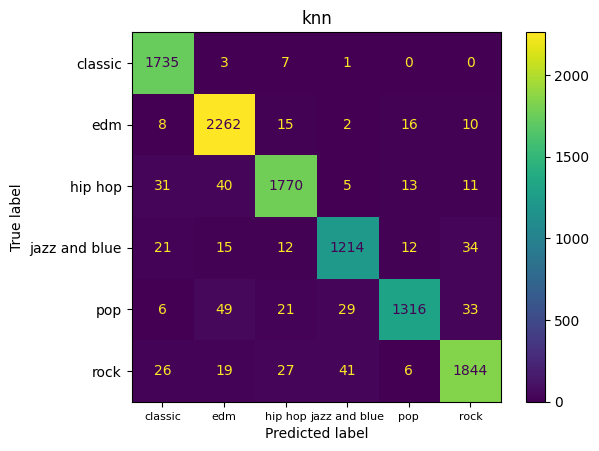

Confusion matrix for  knn  is saved as  knn.png


<Figure size 2000x2000 with 0 Axes>

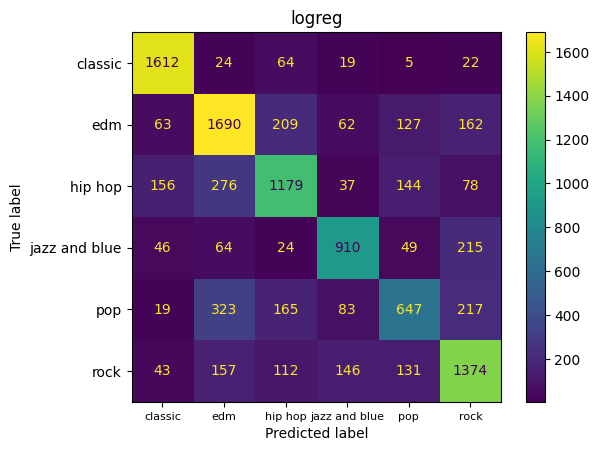

Confusion matrix for  logreg  is saved as  logreg.png


<Figure size 2000x2000 with 0 Axes>

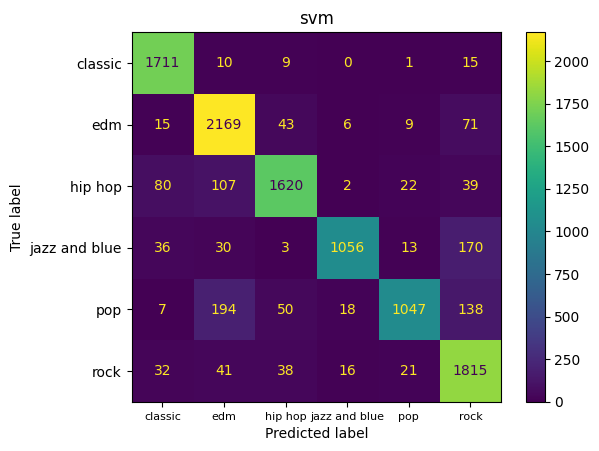

Confusion matrix for  svm  is saved as  svm.png
333/333 [==============================] - 0s 657us/step


<Figure size 2000x2000 with 0 Axes>

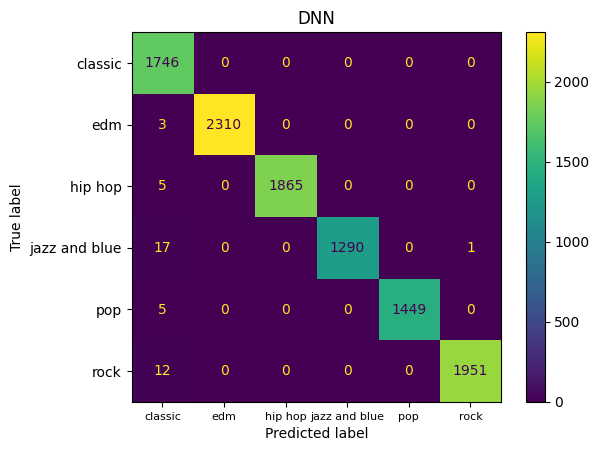

Confusion matrix for  DNN  is saved as  DNN.png


In [65]:
output_folder = 'result'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
else:
    # delete the existing files
    for file in os.listdir(output_folder):
        os.remove(output_folder + '/' + file)
        


cv_result_df = pd.DataFrame(result)
avg_result = cv_result_df.groupby('model').mean().reset_index()
avg_result['model'] += ' Average '
all_result_df = pd.concat([cv_result_df, avg_result], ignore_index=True)
all_result_df = all_result_df[['model', 'accuracy', 'f1', 'precision', 'recall', 'mcc']]

print("Cross-validation results: ")
print(all_result_df)
all_result_df.to_csv(output_folder + '/result.csv', index = False)



print("Confusion matrix for the each model: ")
for model_name, model in models.items():
    plt.figure(figsize=(20, 20))
    if model_name == 'DNN':
        predictions = np.argmax(model.predict(x), axis=1)
    else:
        predictions = model.predict(x)
    cm = confusion_matrix(y, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
    disp.plot()
    plt.title(model_name)
    plt.tick_params(axis='x', labelsize=8)
    plt.savefig(output_folder + '/' + model_name + '.png')
    plt.show()
    print("Confusion matrix for ", model_name, " is saved as ", model_name + '.png')